## CIS 635 Project

### Leveraging Data Mining to Understand and Predict Airbnb Listing Prices

#### Loading required libraries

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from sklearn.preprocessing import StandardScaler

#### Downloading data from kaggle website

The data we are using for this project is hosted in kaggle. [U.S. Airbnb Open Data](https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data)

#### Downloading datasets in csv format

In [ ]:
#Path to the dataset
path = kagglehub.dataset_download("kritikseth/us-airbnb-open-data")

Using Colab cache for faster access to the 'us-airbnb-open-data' dataset.


In [ ]:
#Connecting to files in path
csv_path1 = os.path.join(path, "AB_US_2020.csv")
csv_path2 = os.path.join(path, "AB_US_2023.csv")
#Load the data from CSV files
df1 = pd.read_csv(csv_path1)
df2 = pd.read_csv(csv_path2)
#Previewing the two datasets
print(df1.describe())
print(df2.describe())

/tmp/ipython-input-798040142.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(csv_path1)
/tmp/ipython-input-798040142.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(csv_path2)


                 id       host_id       latitude      longitude  \
count  2.260300e+05  2.260300e+05  226030.000000  226030.000000   
mean   2.547176e+07  9.352385e+07      35.662829    -103.220662   
std    1.317814e+07  9.827422e+07       6.849855      26.222091   
min    1.090000e+02  2.300000e+01      18.920990    -159.714900   
25%    1.515890e+07  1.399275e+07      32.761783    -118.598115   
50%    2.590916e+07  5.138266e+07      37.261125     -97.817200   
75%    3.772624e+07  1.497179e+08      40.724038     -76.919323   
max    4.556085e+07  3.679176e+08      47.734620     -70.995950   

               price  minimum_nights  number_of_reviews  reviews_per_month  \
count  226030.000000    2.260300e+05      226030.000000       177428.00000   
mean      219.716529    4.525490e+02          34.506530            1.43145   
std       570.353609    2.103376e+05          63.602914            1.68321   
min         0.000000    1.000000e+00           0.000000            0.01000   
25%   

In [ ]:
#checking the length of columns in df1 and df2
print(f'Columns in df1 = {len(df1.columns)}')
print(f'Columns in df2 = {len(df2.columns)}')

Columns in df1 = 17
Columns in df2 = 18


In [ ]:
#Selecting columns common in both df1 and df2 before concatenating the dataframes
df1_cols = set(df1.columns)
df2_cols = set(df2.columns)

#Common columns
common = df1_cols & df2_cols
unique_to_df2 = df2_cols - df1_cols
print("Common columns:", common)
print("Columns unique to df2:", unique_to_df2)

Common columns: {'id', 'room_type', 'number_of_reviews', 'host_name', 'latitude', 'city', 'reviews_per_month', 'last_review', 'calculated_host_listings_count', 'price', 'neighbourhood', 'host_id', 'longitude', 'name', 'availability_365', 'neighbourhood_group', 'minimum_nights'}
Columns unique to df2: {'number_of_reviews_ltm'}


In [ ]:
# Finding unique columns in df1 (columns that are in df1 but not in df2)
unique_df1 = df1_cols - df2_cols
print("\nColumns unique to df1:", unique_df1)
# Finding unique columns in df2 (columns that are in df2 but not in df1)
unique_df2 = df2_cols - df1_cols
print("\nColumns unique to df2:", unique_df2)


Columns unique to df1: set()

Columns unique to df2: {'number_of_reviews_ltm'}


In [ ]:
#selecting only common columns in df2 to merge df1.
df2 = df2[list(common)]
len(df2.columns)

17

In [ ]:
#concatenating df1 and df2
joined_df = pd.concat([df1, df2], axis=0, ignore_index=True)
merged_df = joined_df.copy()

In [ ]:
joined_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [ ]:
joined_df.shape

(458177, 17)

The dataframe consists of 458177 entries and 17 variables.

In [ ]:
#Checking the data types of various variables in the dataframe.
print(joined_df.info(show_counts=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458177 entries, 0 to 458176
Data columns (total 17 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   id                              int64  
 1   name                            object 
 2   host_id                         int64  
 3   host_name                       object 
 4   neighbourhood_group             object 
 5   neighbourhood                   object 
 6   latitude                        float64
 7   longitude                       float64
 8   room_type                       object 
 9   price                           int64  
 10  minimum_nights                  int64  
 11  number_of_reviews               int64  
 12  last_review                     object 
 13  reviews_per_month               float64
 14  calculated_host_listings_count  int64  
 15  availability_365                int64  
 16  city                            object 
dtypes: float64(3), int64(7), obje

#### Checking the number of missing values for every column in joined df

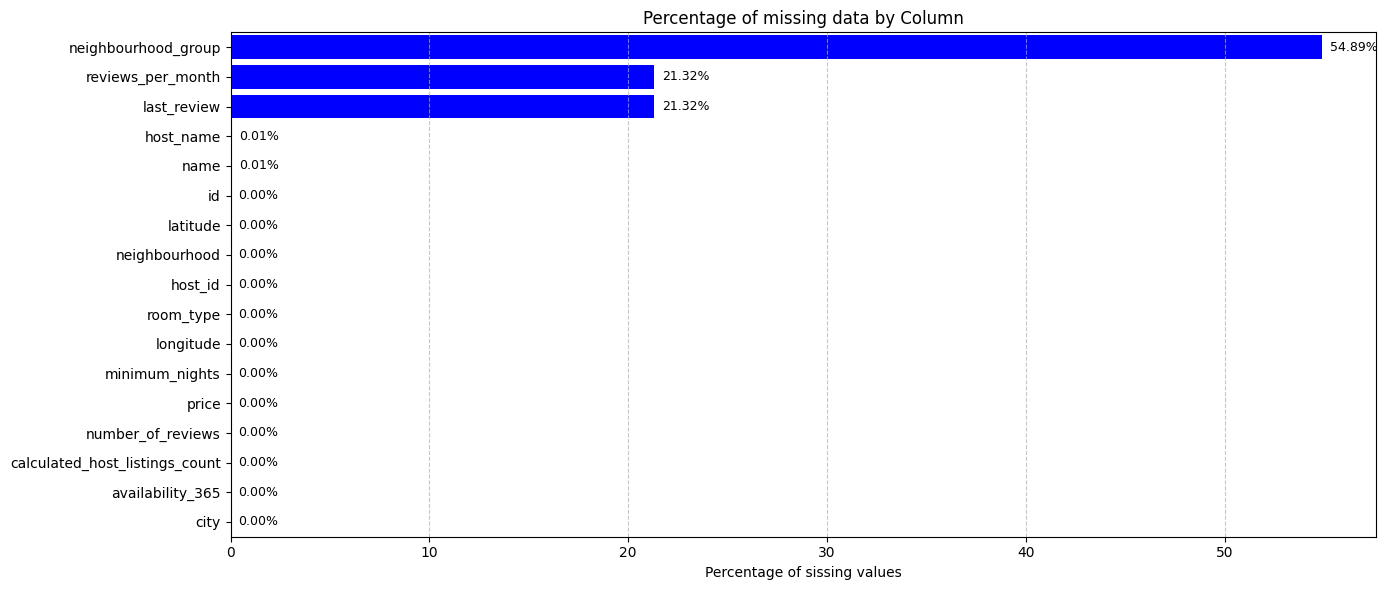

In [ ]:
missing_counts = joined_df.isnull().sum()
missing_df = pd.DataFrame({'column': missing_counts.index,
                           'missing_percent': (missing_counts.values/len(joined_df))*100
                           })
missing_df = missing_df.sort_values(by='missing_percent', ascending=False)
plt.figure(figsize=(14, 6))
bars = plt.barh(missing_df['column'], missing_df['missing_percent'], color='blue')
plt.ylim(-0.5, len(missing_df['column']) - 0.5)
plt.xlabel('Percentage of sissing values')
plt.title('Percentage of missing data by Column')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar, percent in zip(bars, missing_df['missing_percent']):
    plt.text(percent + 0.4, bar.get_y() + bar.get_height()/2,
             f'{percent:.2f}%', va='center', fontsize=9)
plt.tight_layout()
plt.show()

Neighbourhood_group variable has the highest number of missing values at 54.89% of the total entries for neighbourhood_group. Reviews_per_month and last_review both have 21.32% of missing values. host_name and name have 0.01% of missing values which is negligible.

In [ ]:
# Drop 'neighbourhood_group' from cleaned_df
cleaned_df = joined_df.drop(columns=['neighbourhood_group'], errors='ignore')
cleaned_df.shape

(458177, 16)

The consequences of dropping missign values from the dataframe results to a reduction of the number of entries from 450,000 plus to 157742. What other ways do you suggest we consider?

Considered including ID, longitude and latitude however, we can exclude since they are not continuous and it isn't very meaningful to have their summary statistics

In [ ]:
# Checking for duplicates in the cleaned_df
duplicate_rows = cleaned_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

Number of duplicate rows: 290


There are 290 duplicate rows in the data set

In [ ]:
# Removing duplicates
cleaned_df = cleaned_df.drop_duplicates()

In [ ]:
# Summary statistics for numerical columns in the cleaned_df
print(cleaned_df.select_dtypes(include=['number']).describe().T)

                                   count          mean           std  \
id                              457887.0  1.310373e+17  2.785723e+17   
host_id                         457887.0  1.263664e+08  1.363076e+08   
latitude                        457887.0  3.614498e+01  6.057847e+00   
longitude                       457887.0 -1.007265e+02  2.328611e+01   
price                           457887.0  2.398194e+02  8.325533e+02   
minimum_nights                  457887.0  2.302277e+02  1.477817e+05   
number_of_reviews               457887.0  3.777757e+01  7.282810e+01   
reviews_per_month               360490.0  1.536516e+00  1.805348e+00   
calculated_host_listings_count  457887.0  2.339092e+01  8.383689e+01   
availability_365                457887.0  1.703980e+02  1.378415e+02   

                                      min           25%           50%  \
id                                6.00000  1.908486e+07  3.455975e+07   
host_id                          23.00000  1.800776e+07  6.99

In [ ]:
# Combined check of data type, unique values and missingness per column
print("Data Type, Unique Values, and Missingness")
data_summary = pd.DataFrame({
    'dtype': cleaned_df.dtypes,
    'unique_values': cleaned_df.nunique(),
    'missing_percent': cleaned_df.isnull().mean() * 100
}).sort_values(by='missing_percent', ascending=False)

print(data_summary, "\n")

Data Type, Unique Values, and Missingness
                                  dtype  unique_values  missing_percent
reviews_per_month               float64           1476        21.270969
last_review                      object           5524        21.270969
host_name                        object          42550         0.009828
name                             object         375684         0.009609
neighbourhood                    object           1459         0.000000
latitude                        float64         244267         0.000000
id                                int64         370252         0.000000
host_id                           int64         188040         0.000000
room_type                        object              4         0.000000
longitude                       float64         250621         0.000000
minimum_nights                    int64            202         0.000000
price                             int64           2773         0.000000
number_of_reviews     

review_per_month and last_review have the highest missingness at 21.261699 percent.

In [ ]:
# Removing the NANs
cleaned_df = cleaned_df.dropna(subset=['reviews_per_month', 'last_review'])

The skewness results show that most numeric features in the dataset are highly right-skewed, particularly price, minimum_nights, and calculated_host_listings_count, indicating the presence of extreme high values or outliers, while availability_365 is nearly symmetric.

Logical Consistency checks

In [ ]:
# Checking for the logical consistency of the variables for reasonable ranges
print("Logical Consistency Checks")
# Checking price validity
if 'price' in cleaned_df.columns:
    invalid_prices = cleaned_df[cleaned_df['price'] <= 0]
    print(f"Listings with invalid price values (<=0): {len(invalid_prices)}")

# Range checks for the other variables
# Check ranges for numeric variables
num_cols = cleaned_df.select_dtypes(include=['number']).drop(
    columns=['id','price','host_id','latitude','longitude'], errors='ignore'
)
for col in num_cols.columns:
    print(f"{col} range: {num_cols[col].min()} - {num_cols[col].max()}")


Logical Consistency Checks
Listings with invalid price values (<=0): 67
minimum_nights range: 1 - 100000000
number_of_reviews range: 1 - 3091
reviews_per_month range: 0.01 - 101.42
calculated_host_listings_count range: 1 - 1003
availability_365 range: 0 - 365


The dataset is mostly logically consistent, with only 37 listings having invalid prices,other variables having a little bit of extreme values, and geographic coordinates falling within valid U.S. locations, their territories, and border territories.

In [ ]:
# Remove invalid prices
cleaned_df = cleaned_df[cleaned_df['price'] > 0].copy()
# Verify
invalid_prices = cleaned_df[cleaned_df['price'] <= 0]
print(f"Listings with invalid price values (<=0): {len(invalid_prices)}")


Listings with invalid price values (<=0): 0


Since it is not logical to have prices which are <= 0 we have removed that from the data set

Skewness of Numeric Variables

In [ ]:
# Select numeric columns (exclude IDs and coordinates)
num_cols = cleaned_df.select_dtypes(include=['number']).drop(columns=['id', 'host_id', 'longitude', 'latitude'], errors='ignore')
# Compute skewness
print("Skewness of Numeric Columns")
skew_values = num_cols.skew().sort_values(ascending=False)
print(skew_values, "\n")

Skewness of Numeric Columns
minimum_nights                    600.352377
price                              87.502707
calculated_host_listings_count     10.021990
reviews_per_month                   4.808820
number_of_reviews                   3.809847
availability_365                    0.135572
dtype: float64 



The variables in the data set are right skewed with only availability_365 being symmetrical

Correlation Analysis

In [ ]:
corr_matrix = num_cols.corr()
display(corr_matrix.style.background_gradient(cmap='coolwarm').format("{:.2f}"))

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
price,1.00,-0.00,-0.03,-0.03,0.02,0.03
minimum_nights,-0.00,1.00,-0.00,-0.00,-0.00,-0.00
number_of_reviews,-0.03,-0.00,1.00,0.65,-0.09,0.03
reviews_per_month,-0.03,-0.00,0.65,1.00,-0.09,0.06
calculated_host_listings_count,0.02,-0.00,-0.09,-0.09,1.00,0.13
availability_365,0.03,-0.00,0.03,0.06,0.13,1.00


Most numeric features are weakly correlated, with the only moderate relationship being between number_of_reviews and reviews_per_month, while all other variables vary largely and independently.

Outlier Detection and Removal using the Z-score Method and IQR

Shape after robust Z-score outlier removal: (343662, 16)


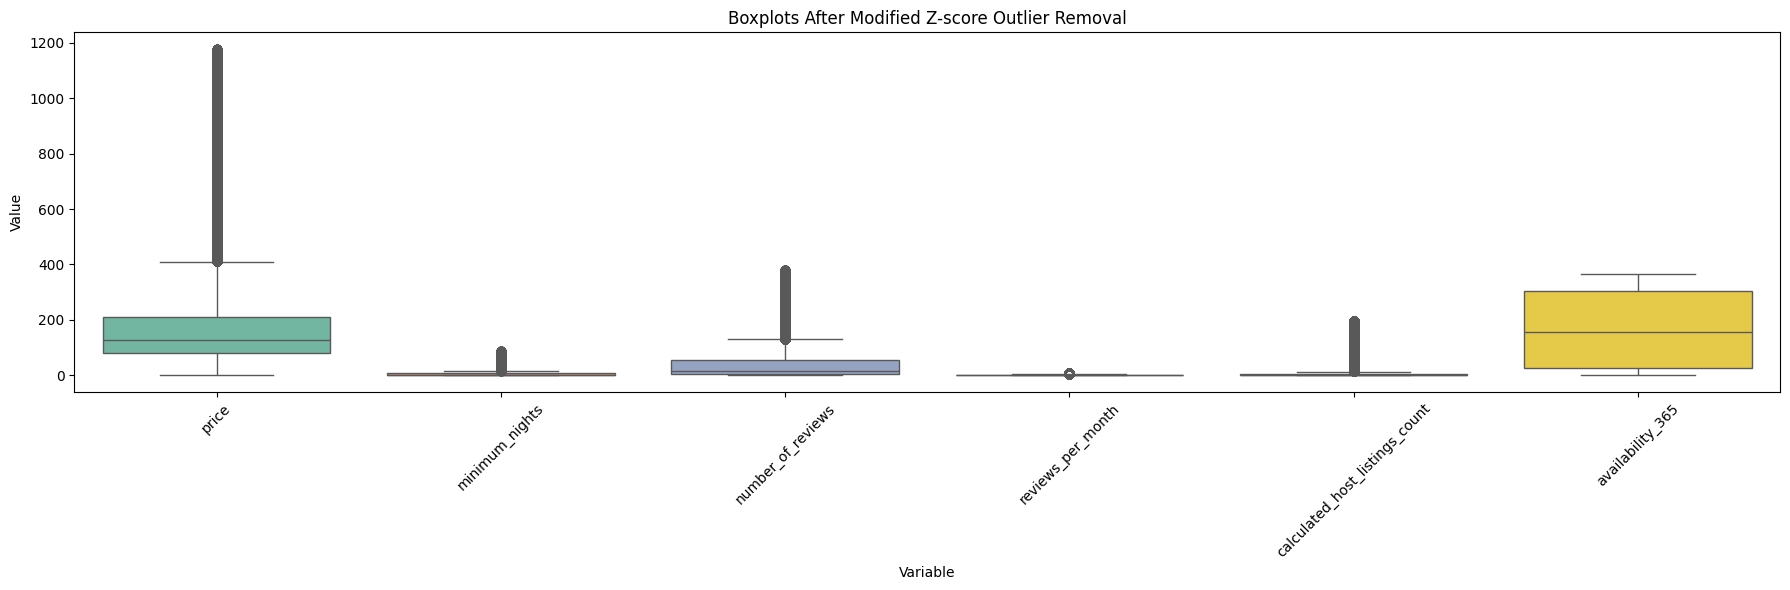

Final dataset shape after Modified Z-score + IQR filtering: (181256, 16)


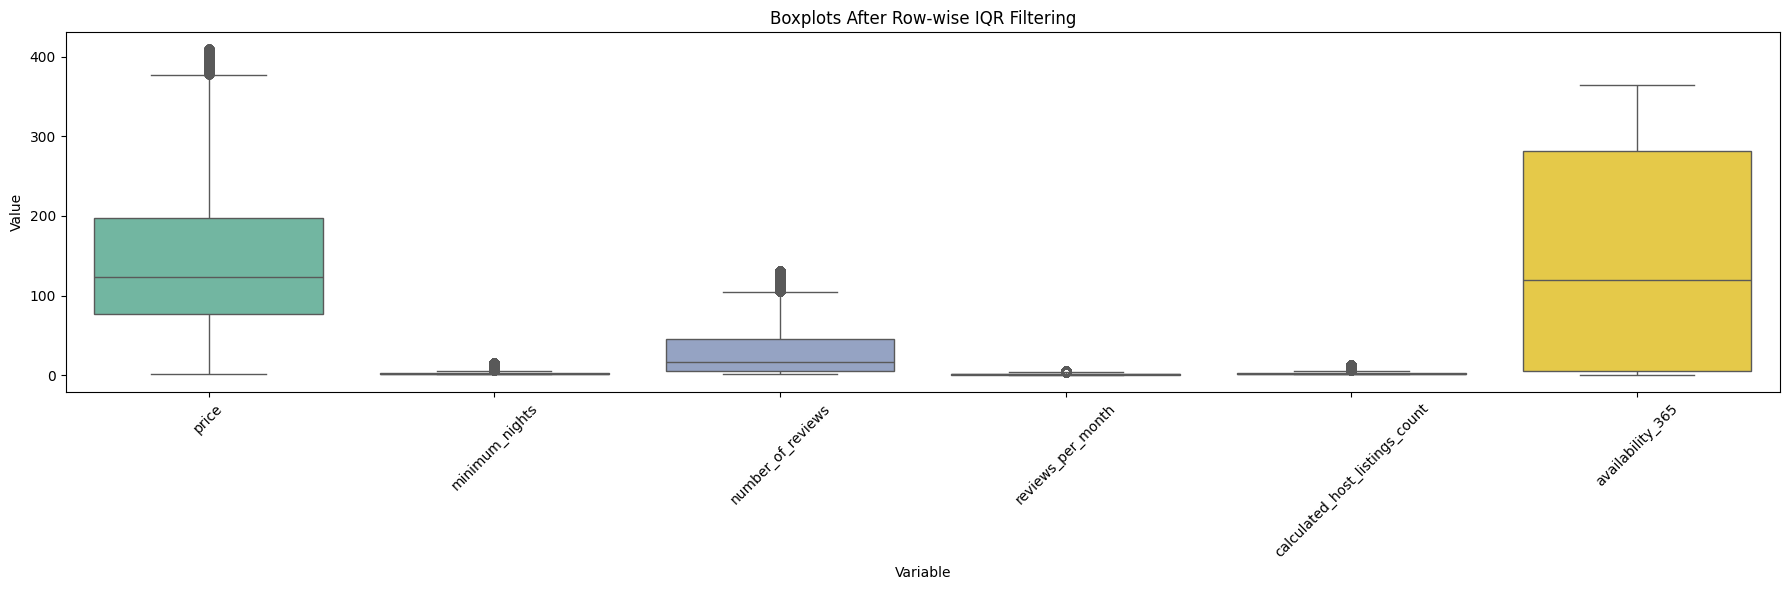

In [ ]:
# Outlier detection and removal using 2 methods IQR and Z-score
# Select numeric columns (exclude IDs and coordinates)
num_cols = cleaned_df.select_dtypes(include=['number']).drop(
    columns=['id','host_id','latitude','longitude'], errors='ignore'
)
# Boxplot 1: After Z-score removal
medians = num_cols.median()
mad = num_cols.apply(lambda x: np.median(np.abs(x - np.median(x))), axis=0)
mod_z_scores = 0.6745 * (num_cols - medians) / mad
percentile = 0.99
zscore_thresholds = mod_z_scores.abs().quantile(percentile)
z_mask = (mod_z_scores.abs() <= zscore_thresholds).all(axis=1)
cleaned_df_dynamic = cleaned_df.loc[z_mask].copy()
print(f"Shape after robust Z-score outlier removal: {cleaned_df_dynamic.shape}")

numeric_cols_dynamic = cleaned_df_dynamic.select_dtypes(include=['number']).drop(
    columns=['id','host_id','latitude','longitude'], errors='ignore'
)
melted_z = numeric_cols_dynamic.melt(var_name='Variable', value_name='Value')
plt.figure(figsize=(18,6))
sns.boxplot(
    x='Variable',
    y='Value',
    data=melted_z,
    hue='Variable',
    dodge=False,
    palette='Set2',
    showfliers=True
)
plt.legend([], [], frameon=False)
plt.xticks(rotation=45)
plt.title('Boxplots After Modified Z-score Outlier Removal')
plt.tight_layout()
plt.show()

# Boxplot 2: After row-wise IQR filtering
iqr_factor = 1.5
iqr_mask = np.ones(len(cleaned_df_dynamic), dtype=bool)
for col in numeric_cols_dynamic.columns:
    Q1 = numeric_cols_dynamic[col].quantile(0.25)
    Q3 = numeric_cols_dynamic[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - iqr_factor * IQR
    upper = Q3 + iqr_factor * IQR
    iqr_mask &= (numeric_cols_dynamic[col] >= lower) & (numeric_cols_dynamic[col] <= upper)
cleaned_df_final = cleaned_df_dynamic.loc[iqr_mask].copy()
print(f"Final dataset shape after Modified Z-score + IQR filtering: {cleaned_df_final.shape}")
numeric_cols_final = cleaned_df_final.select_dtypes(include=['number']).drop(
    columns=['id','host_id','latitude','longitude'], errors='ignore'
)
melted_iqr = numeric_cols_final.melt(var_name='Variable', value_name='Value')
plt.figure(figsize=(18,6))
sns.boxplot(
    x='Variable',
    y='Value',
    data=melted_iqr,
    hue='Variable',
    dodge=False,
    palette='Set2',
    showfliers=True
)
plt.legend([], [], frameon=False)
plt.xticks(rotation=45)
plt.title('Boxplots After Row-wise IQR Filtering')
plt.tight_layout()
plt.show()

There are extreme outliers visible in the variables. Chose to use the modified Z-score method which will be a robust method to deal with the extreme outliers then afterwards use the IQR based methods to remove rows with moderate outliers

Data Visualization

Data Scaling and Feature engineering